# Tutorial for mvTCR

First we download the mvTCR package and the preprocessed Tumor-infiltrating Lymphocyte (TIL) dataset. The unpreprocessed dataset can be downloaded at https://github.com/ncborcherding/utility

In [1]:
!git clone https://github.com/SchubertLab/mvTCR ../scarches/models/mvTCR

fatal: destination path '../scarches/models/mvTCR' already exists and is not an empty directory.


In [2]:
import gdown
import os
url = 'https://drive.google.com/uc?id=1Zt8G5wsLaPW6xhNFhh041i0oMAX68tgi'
output = 'borcherding.h5ad'
if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

In [3]:
%%time
import torch
import scanpy as sc

CPU times: user 2.06 s, sys: 1.67 s, total: 3.73 s
Wall time: 10.8 s


In [4]:
import sys
sys.path.append('../scarches/models/mvTCR')
import tcr_embedding
import tcr_embedding.utils_training as utils
from tcr_embedding.models.mixture_modules.moe import MoEModel
from tcr_embedding.utils_preprocessing import group_shuffle_split

In [5]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (6, 6)

%load_ext autoreload
%autoreload 2

In [6]:
random_seed = 42
utils.fix_seeds(random_seed)

# Set hyperparameters

Here the hyperparameters can be set

In [7]:
N = 100000  # number of subsamples

In [8]:
holdout_cohorts = ['GSE154826',  # Lung with normal and tumor cells 18387 cells
                   'GSE162500']  # Lung with 18850 cells

# maps each batch to an index, important is that the holdout cohorts are at the last positions
mapper = {'GSE123814': 0, 'GSE114724': 1, 'GSE139555': 2, 'GSE145370': 3,
          'GSE180268': 4, 'GSE176021': 5, 'GSE148190': 6, 'GSE159251': 7,
          'CCR-20-4394': 8, 'PRJNA705464': 9, 'GSE121636': 10, 'GSE154826': 11, 'GSE162500': 12}

In [9]:
# Parameters for model and training
params_architecture = {'batch_size': 512,
                       'learning_rate': 0.0006664047426647477,
                       'loss_weights': [1.0, 0.016182440457269676, 1.0110670042409596e-10],
                       'joint': {'activation': 'leakyrelu',
                                 'batch_norm': True,
                                 'dropout': 0.05,
                                 'hdim': 100,
                                 'losses': ['MSE', 'CE'],
                                 'num_layers': 2,
                                 'shared_hidden': [100, 100],
                                 'zdim': 50,
                                 'c_embedding_dim': 20,
                                 'use_embedding_for_cond': True,
                                 'num_conditional_labels': 11,
                                 'cond_dim': 20,
                                 'cond_input': True},
                       'rna': {'activation': 'leakyrelu',
                               'batch_norm': True,
                               'dropout': 0.05,
                               'gene_hidden': [500, 500, 500],
                               'num_layers': 3,
                               'output_activation': 'linear',
                               'xdim': 5000},
                       'tcr': {'embedding_size': 64,
                               'num_heads': 4,
                               'forward_expansion': 4,
                               'encoding_layers': 1,
                               'decoding_layers': 1,
                               'dropout': 0.25,
                               'max_tcr_length': 30,
                               'num_seq_labels': 24}
                      }

params_experiment = {
    'model_name': 'moe',
    'n_epochs': 200,
    'early_stop': 5,
    'balanced_sampling': 'clonotype',
    'kl_annealing_epochs': None,
    'metadata': ['clonotype', 'Sample', 'Type', 'Tissue', 'Tissue+Type', 'functional.cluster'],
    'save_path': 'saved_models',
    'conditional': 'Cohort'
}

params_optimization = {
    'name': 'pseudo_metric',
    'prediction_labels':
        {'clonotype': 1,
         'Tissue+Type': 10}
}

# Load Data

In [10]:
adata = sc.read_h5ad('borcherding.h5ad')
adata.obs['Cohort_id'] = adata.obs['Cohort'].map(mapper)
adata.obs['Tissue+Type'] = [f'{tissue}.{type_}' for tissue, type_ in zip(adata.obs['Tissue'], adata.obs['Type'])]
metadata = ['Tissue', 'Type', 'Tissue+Type', 'functional.cluster', 'set', 'Cohort']

In [11]:
sc.pp.subsample(adata, n_obs=N)

# Train model on atlas dataset

We initialize a model and train it on the atlas dataset until convergence

In [12]:
# Split data into training and hold-out dataset
adata.obs['set'] = 'train'
adata.obs['set'][adata.obs['Cohort'].isin(holdout_cohorts)] = 'hold_out'
adata.obsm['Cohort'] = torch.nn.functional.one_hot(torch.tensor(adata.obs['Cohort_id'])).numpy()

# Stratified splitting of training into train and val. The val set is used for early stopping
adata_train = adata[~adata.obs['Cohort'].isin(holdout_cohorts)].copy()
adata_train.obsm['Cohort'] = torch.nn.functional.one_hot(torch.tensor(adata_train.obs['Cohort_id'])).numpy()
train, val = group_shuffle_split(adata_train, group_col='clonotype', val_split=0.2, random_seed=random_seed)
adata_train.obs.loc[val.obs.index, 'set'] = 'val'

In [13]:
model = MoEModel(adata_train, params_architecture, params_experiment['balanced_sampling'], params_experiment['metadata'],
                 params_experiment['conditional'], params_optimization)

In [14]:
model.train(params_experiment['n_epochs'], params_architecture['batch_size'], params_architecture['learning_rate'],
            params_architecture['loss_weights'], params_experiment['kl_annealing_epochs'],
            params_experiment['early_stop'], params_experiment['save_path'])

 36%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 73/200 [17:56<31:13, 14.75s/it]

Early stopped


# Finetune model

To finetune the model, we load the pretrained model from the previous step. Then we initizalize additional embedding vectors for the query datasets and freeze all weights except the embedding layer

In [15]:
# Separate holdout data and create a validation set (20%) for early stopping
adata_hold_out = adata[adata.obs['Cohort'].isin(holdout_cohorts)].copy()
adata_hold_out.obsm['Cohort'] = torch.nn.functional.one_hot(torch.tensor(adata_hold_out.obs['Cohort_id'])).numpy()
train, val = group_shuffle_split(adata_hold_out, group_col='clonotype', val_split=0.2, random_seed=random_seed)
adata_hold_out.obs['set'] = 'train'
adata_hold_out.obs.loc[val.obs.index, 'set'] = 'val'

In [16]:
# Load pretrained model
model = utils.load_model(adata_train, f'../../../notebooks/saved_models/best_model_by_metric.pt')
model.add_new_embeddings(len(holdout_cohorts))  # add new cond embeddings
model.freeze_all_weights_except_cond_embeddings()
model.change_adata(adata_hold_out)  # change the adata to finetune on the holdout data

In [17]:
# Finetune model
model.train(n_epochs=200, batch_size=params_architecture['batch_size'], learning_rate=params_architecture['learning_rate'], 
            loss_weights=params_architecture['loss_weights'], kl_annealing_epochs=None, early_stop=5, 
            save_path=f'saved_models/finetuning/', comet=None)

  3%|███████▎                                                                                                                                                                                                                                            | 6/200 [00:05<02:54,  1.11it/s]

Early stopped


# Get latent representation and visualize using UMAP

After finetuning, we use the model to predict the latent representation for all cells and visualize them using UMAP

In [18]:
model = utils.load_model(adata_hold_out, f'../../../notebooks/saved_models/finetuning/best_model_by_metric.pt')

In [19]:
latent_adata = model.get_latent(adata, metadata=metadata, return_mean=True)

In [20]:
# For visualization purpose
latent_adata.obs['Cohort_held_out'] = latent_adata.obs['Cohort'].copy()
latent_adata.obs.loc[~latent_adata.obs['Cohort'].isin(holdout_cohorts), 'Cohort_held_out'] = None

In [21]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

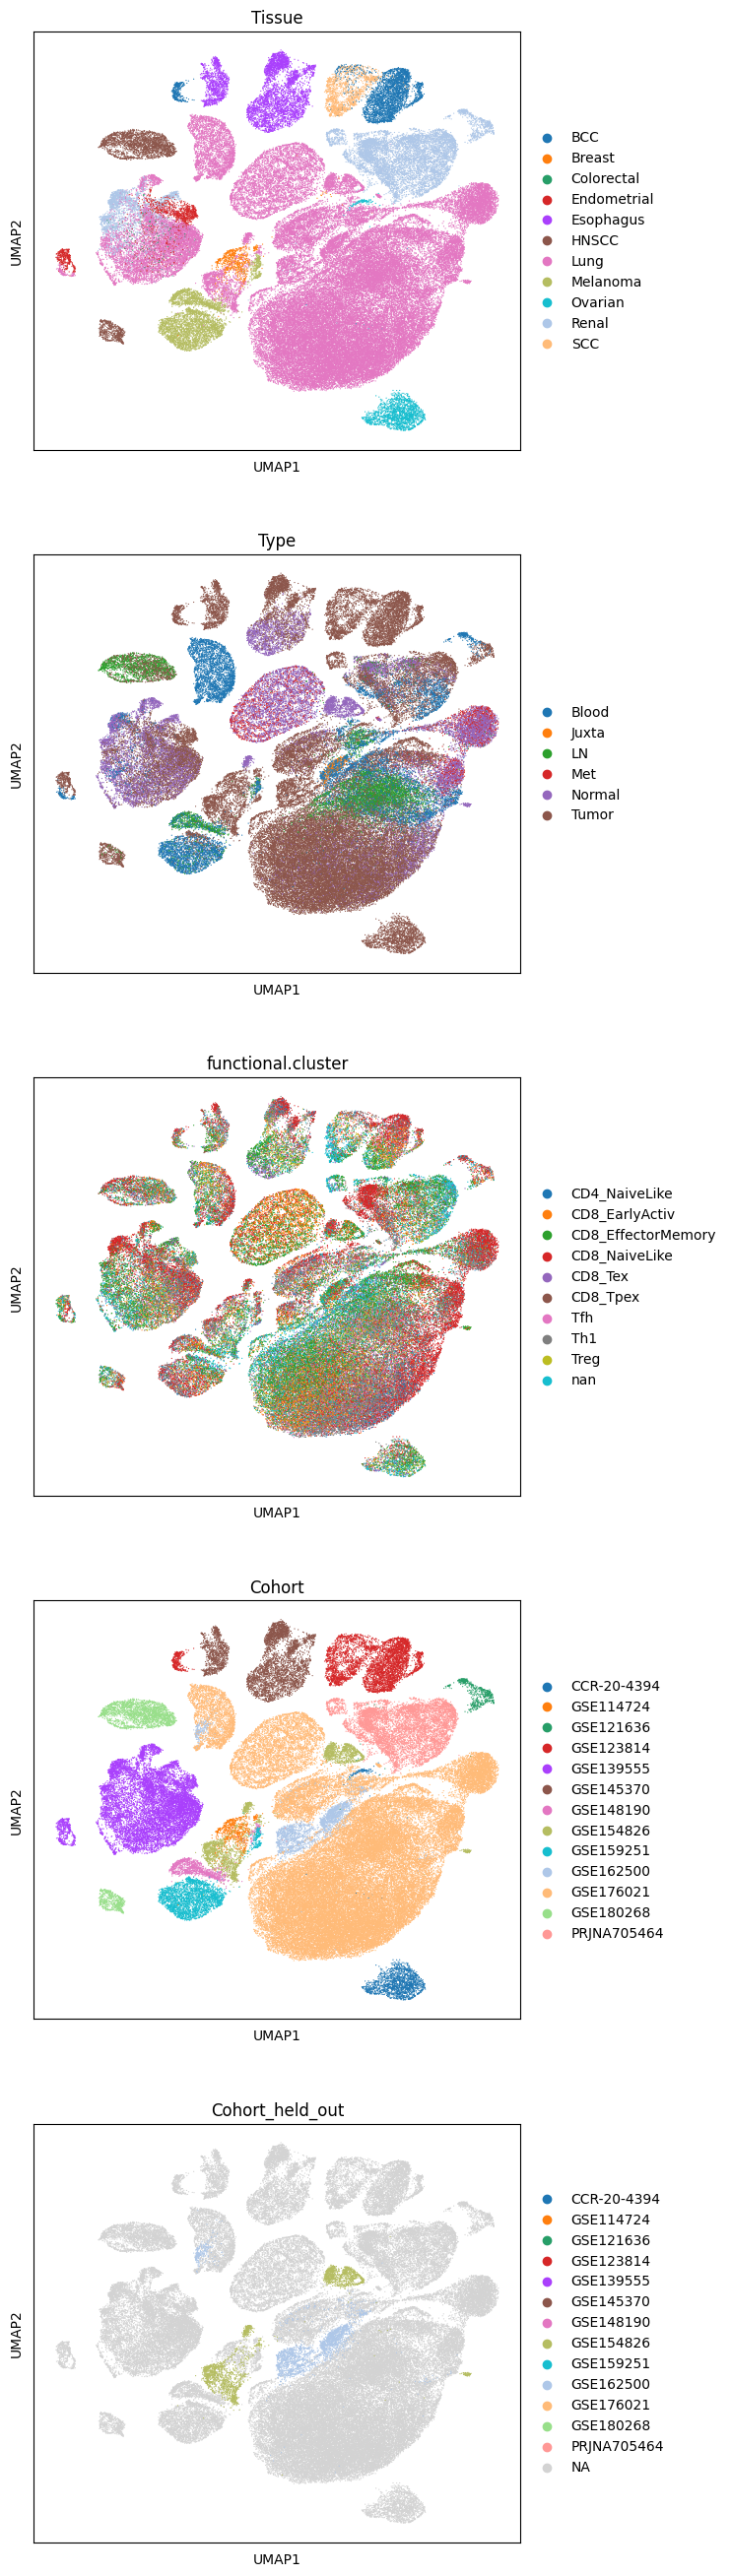

In [23]:
sc.pl.umap(latent_adata, color=['Tissue', 'Type', 'functional.cluster', 'Cohort', 'Cohort_held_out'], size=3, ncols=1)